# 성능개선 기법 실습

# 모듈 정의

## train.py
- 모델 학습과 검증 함수 정의

In [1]:
import os
os.makedirs('module', exist_ok=True) #module이라는 패키지를 만든 것이다.

In [1]:
%%writefile module/train.py

#이 셀을 실행을 하면 위의 파일에 내용을 쓰라는 이야기이다. 이 점을 반드시 기억할 것!
import torch
import time

# multi와 binary 정확도 계산이 다르다.


#다중분류 문제에 대해 평가하는 코드.
def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset) # 전체 데이터수---전체 데이터수를 구하기 위해 dataloader 중에서도 dataset을 구한다.
    num_batches = len(dataloader)  #  step 수
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) #모델에게 추론을 시키는 부분의 코드이다.
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1) #label을 뽑아내는 과정이 틀리다.
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_batches
        test_accuracy /= size  #전체 개수로 나눈다.
    return test_loss, test_accuracy  #결국 test_loss, test_accuracy를 return 한다. 



#이중분류에 대해 평가하는 코드. 이렇게 분류하는 이유는 함수도 다르고, 프로세스도 다르기 때문이다.
def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32) #정확도가 일정 기준 이상이면,이를 pred_label에 추가.
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_batches
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    


#train 해주는 코드를 작성했다.
def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) #총 데이터수

    for batch, (X, y) in enumerate(dataloader): #batch의 수와 x,y도 출력을 시도!
        X, y = X.to(device), y.to(device)
        pred = model(X) #모델 학습

        loss = loss_fn(pred, y) #loss 구하기

        optimizer.zero_grad() #gradient 초기화
        loss.backward()
        optimizer.step()
        #이를 통해 한 step의 학습이 끝났다.
        
    if mode == 'binary': #모드에 따라서 train 관련값이 어떻게 반영이 될 것인지에 대한 놈이다.
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy


#최종적으로 학습을 시킨다. 학습을 하고, 검증을 하는 것 2가지를 같이 한다.
def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, 
        save_best_model=True, save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary',
    lr_scheduler=None):
    """
    모델을 학습시키는 함수

    [parameter]
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
    [return]
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
        lr_scheduler:Learning Rate 스케쥴러 객체. default: None
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
    #이런 거는 상황에 맞게 알맞게 사용하면 된다.
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        #train이라는 함수를 호출하면, train_loss와 train_accuracy를 return 할 것이다.
       #이 과정을 통해 train 과정이 끝이 난다.(한 epoch의 train이 끝이 난다.)
    
        # 검증 - test_xxxx_classsification() 함수를 호출한다. mode가 무엇인가에 따라 코드의 동작 방식이 달라진다.
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        ####LR Scheduler에게 lr 변경요청
        if lr_scheduler:
            lr_scheduler.step()
        
        #한 에폭의 검증 결과를 각 list에 추가한다.
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        #로그 출력. 현재 epoch, train loss, train accucracy 등을 세세히 출력한다.
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리 (early stopping이 true인지 false인지 따져 보는 것이다.)           
        if early_stopping: #true라면 스코어를 갱신하고 trigger를 0으로 설정한다.
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list


#이 코드는 복습 시간에 정말 세세하게 코드 리뷰를 하도록 하자.

Overwriting module/train.py


## data.py
- dataset 생성 함수 제공 모듈

In [2]:
%%writefile module/data.py

#이번엔 data.py라는 이름을 가진 파일에 저장을 하자.
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    #dataset과 dataloader를 정의한다.
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader #dataloader를 return 하면 결과적으로는 dataset도 같이 포함하는 거야. 위에 코드 보면 알겠지?

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


In [3]:
from module import data

In [4]:
mnist_trainloader = data.load_mnist_dataset("datasets",200,True) #이런 식으로 trainset를 제공한다.
mnist_testloader = data.load_mnist_dataset("datasets",200,False) #이런 식으로 testset을 제공한다.





In [5]:
#데이터수

len(mnist_trainloader.dataset), len(mnist_testloader.dataset)

(60000, 10000)

In [6]:
#step수------데이터수에서 batch_size를 나누는 것이다.

len(mnist_trainloader), len(mnist_testloader)

(300, 50)

### import

In [11]:
import torch
import torch.nn as nn

import torchinfo


from module import train, data
import os
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu" #device에 대한 if문.
device

'cpu'

## 하이퍼파라미터, 변수 정의

In [12]:
LR = 0.001
N_EPOCH = 10
BATCH_SIZE = 200


#DATASET, MODEL 을 저장할 ROOT 디렉토리 경로
DATASET_ROOT_PATH = 'datasets'
MODEL_SAVE_ROOT_PATH = 'models'

#이런 식으로 자주 쓰이거나, 나중에 튜닝의 대상이 되는 변수들은 한 곳에 모아서 정의를 하는 것이 좋다.
#이 팁은 다른 개발을 할 때도 요긴하게 쓰인다.



# Data 준비

## mnist 데이터 로딩

In [13]:
train_loader = data.load_mnist_dataset(DATASET_ROOT_PATH,BATCH_SIZE,True)
test_loader = data.load_mnist_dataset(DATASET_ROOT_PATH,BATCH_SIZE,False)




# 모델의 크기 변경에 따른 성능변화

In [14]:
#자, 일단 작은 크기의 모델을 한번 적용시켜보자.

class SmallSizeModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.output = nn.Linear(784,10) #in:feature의 수. (1*28*28), out: class 개수------바로 출력하는 것이다.
        
        
    def forward(self,X):
        out = nn.Flatten()(X)
        out =self.output(out)
        return out
        

In [16]:
small_model = SmallSizeModel()
torchinfo.summary(small_model,(BATCH_SIZE,1,28,28))

#summary를 보면 알겠지만, 뭔가가 많이 있지는 않다.

Layer (type:depth-idx)                   Output Shape              Param #
SmallSizeModel                           [200, 10]                 --
├─Linear: 1-1                            [200, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 1.57
Input size (MB): 0.63
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.67

In [18]:
#loss 

loss_fn = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(small_model.parameters(),lr=LR)



In [19]:
#train -> module.fit()
#train.fit() 으로 한번에 학습이 된다.
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = \
train.fit(train_loader,test_loader,small_model,loss_fn,optimizer,N_EPOCH,save_best_model=True,
          save_model_path=os.path.join(MODEL_SAVE_ROOT_PATH,"small_model.pth"),device=device,mode="multi")

Epoch[1/10] - Train loss: 0.44705 Train Accucracy: 0.88607 || Validation Loss: 0.42795 Validation Accuracy: 0.89460
저장: 1 - 이전 : inf, 현재: 0.4279545383155346
Epoch[2/10] - Train loss: 0.35787 Train Accucracy: 0.90365 || Validation Loss: 0.34362 Validation Accuracy: 0.90870
저장: 2 - 이전 : 0.4279545383155346, 현재: 0.34361504584550856
Epoch[3/10] - Train loss: 0.32298 Train Accucracy: 0.91173 || Validation Loss: 0.31384 Validation Accuracy: 0.91350
저장: 3 - 이전 : 0.34361504584550856, 현재: 0.3138397286832333
Epoch[4/10] - Train loss: 0.30486 Train Accucracy: 0.91592 || Validation Loss: 0.29697 Validation Accuracy: 0.91750
저장: 4 - 이전 : 0.3138397286832333, 현재: 0.29696669973433015
Epoch[5/10] - Train loss: 0.29288 Train Accucracy: 0.91913 || Validation Loss: 0.28789 Validation Accuracy: 0.92020
저장: 5 - 이전 : 0.29696669973433015, 현재: 0.28788589537143705
Epoch[6/10] - Train loss: 0.28375 Train Accucracy: 0.92162 || Validation Loss: 0.28168 Validation Accuracy: 0.92090
저장: 6 - 이전 : 0.28788589537143705, 

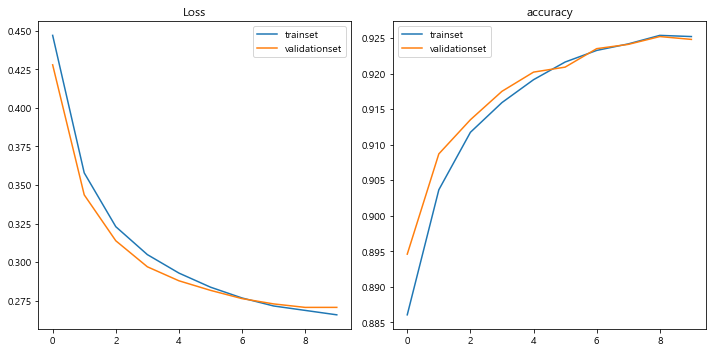

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list,label="trainset")
plt.plot(valid_loss_list,label="validationset")
plt.title("Loss")
plt.legend()


plt.subplot(1,2,2)
plt.plot(train_acc_list,label="trainset")
plt.plot(valid_acc_list,label="validationset")
plt.title("accuracy")
plt.legend()

plt.tight_layout()
plt.show()


#뭐 어쨌든 loss는 줄어들고 accuracy는 줄어든 것을 볼 수 있다. 근데, epoch을 더 돌려야 하는 것은 자명하다.
#근본적인 이유는 모델의 크기가 작아서 학습 능력이 떨어지는 것이다.




In [13]:
#nn.Sequential을 이용해서 layer block을 정의하자.
#### 여러 layer 들을 묶어준다. (묶어서 하나로 표현을 해 준다.)



#모델을 만들 때, 이런 식으로 간단하게 만들기도 한다.
#이 부분은 복습할 때 세세히 학습을 하도록 하자.
layer_block = nn.Sequential(
    
    nn.Linear(20,30),
    nn.ReLU()
)


a = torch.ones(1,20)
r = layer_block(a)
r.shape
r#음수는 0이 나오고 양수는 0이 아닌 수가 나온다.

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.6560, 0.5506, 1.5307, 0.0000, 1.3514,
         0.0000, 0.0000, 0.3279, 0.8142, 0.0000, 0.0000, 0.0895, 0.0000, 0.4381,
         0.0000, 0.0000, 0.0000, 0.0023, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1003, 0.0362]], grad_fn=<ReluBackward0>)

In [21]:
#자, 이번에는 bigsize 모델을 한번 만들어보자.
## nn.Sequential을 통해 중간 과정을 더 간단하게 만들 수 있다.

class BigSizeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Linear(784,2048),nn.ReLU()) #nn.ReLU에 넣겠다는 의미이다.
        self.b2 = nn.Sequential(nn.Linear(2048,1024),nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024,512),nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512,256),nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256,128),nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128,64),nn.ReLU())
        
        #최종 결과 10개를 출력하게 될 것이다.
        self.output = nn.Linear(64,10)
        
    def forward(self,X):
        
        #이런 식으로 각 블록을 통과한다. 이 코드가 없으면, 블록이 정의만 되지 블록을 통과하지는 못한다.
        X = nn.Flatten()(X) #객체를 생성하고 코드를 실행 시키는 것을 항상 잊지 마라!
        out =self.b1(X)
        out =self.b2(out)
        out =self.b3(out)
        out =self.b4(out)
        out =self.b5(out)
        out =self.b6(out)
        return self.output(out)
    

In [22]:
big_model = BigSizeModel()

torchinfo.summary(big_model,(BATCH_SIZE,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
BigSizeModel                             [200, 10]                 --
├─Sequential: 1-1                        [200, 2048]               --
│    └─Linear: 2-1                       [200, 2048]               1,607,680
│    └─ReLU: 2-2                         [200, 2048]               --
├─Sequential: 1-2                        [200, 1024]               --
│    └─Linear: 2-3                       [200, 1024]               2,098,176
│    └─ReLU: 2-4                         [200, 1024]               --
├─Sequential: 1-3                        [200, 512]                --
│    └─Linear: 2-5                       [200, 512]                524,800
│    └─ReLU: 2-6                         [200, 512]                --
├─Sequential: 1-4                        [200, 256]                --
│    └─Linear: 2-7                       [200, 256]                131,328
│    └─ReLU: 2-8                         [200, 256]          

In [23]:
#loss_fn, optimizer 등을 새로 적어주는 것이 좋다.

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters())

In [24]:
#학습----위의 것과 다른 것은 파일 등의 이름이다.
#시간이 조금 걸린다.
#train -> module.fit()
#train.fit() 으로 한번에 학습이 된다.
train_loss_list2, train_acc_list2, valid_loss_list2, valid_acc_list2 = \
train.fit(train_loader,test_loader,big_model,loss_fn,optimizer,N_EPOCH,save_best_model=True,
          save_model_path=os.path.join(MODEL_SAVE_ROOT_PATH,"big2_model.pth"),device=device,mode="multi")

Epoch[1/10] - Train loss: 0.11916 Train Accucracy: 0.96580 || Validation Loss: 0.12917 Validation Accuracy: 0.96260
저장: 1 - 이전 : inf, 현재: 0.12916784353554248
Epoch[2/10] - Train loss: 0.07325 Train Accucracy: 0.97773 || Validation Loss: 0.10755 Validation Accuracy: 0.96990
저장: 2 - 이전 : 0.12916784353554248, 현재: 0.1075451648980379
Epoch[3/10] - Train loss: 0.06034 Train Accucracy: 0.98180 || Validation Loss: 0.10540 Validation Accuracy: 0.96920
저장: 3 - 이전 : 0.1075451648980379, 현재: 0.10539983634836972
Epoch[4/10] - Train loss: 0.05157 Train Accucracy: 0.98395 || Validation Loss: 0.10138 Validation Accuracy: 0.97170
저장: 4 - 이전 : 0.10539983634836972, 현재: 0.10138087772764265
Epoch[5/10] - Train loss: 0.03626 Train Accucracy: 0.98932 || Validation Loss: 0.08837 Validation Accuracy: 0.97840
저장: 5 - 이전 : 0.10138087772764265, 현재: 0.08837471866048872
Epoch[6/10] - Train loss: 0.01897 Train Accucracy: 0.99473 || Validation Loss: 0.07289 Validation Accuracy: 0.98170
저장: 6 - 이전 : 0.08837471866048872

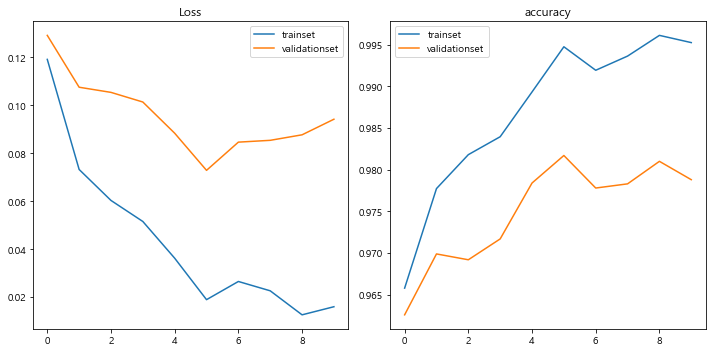

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list2,label="trainset")
plt.plot(valid_loss_list2,label="validationset")
plt.title("Loss")
plt.legend()


plt.subplot(1,2,2)
plt.plot(train_acc_list2,label="trainset")
plt.plot(valid_acc_list2,label="validationset")
plt.title("accuracy")
plt.legend()

plt.tight_layout()
plt.show()


#사이즈가 커지니까.... 여윽시 성능이 더 좋아지는 것 갑다잉.



# Dropout 예제
- dropout 각 레이어에 적용
    - dropout은 nn.Dropout 객체를 사용
    - 객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    - Drop시킬 노드를 가진 Layer 뒤에 추가한다.

In [25]:
#Model은 Model인데, dropout을 적용시키는 model이다.

class DropoutModel(nn.Module):
    
    
    def __init__(self,drop_rate=0.5):
        super().__init__()
        self.b1 = nn.Sequential(nn.Linear(784,256), nn.ReLU(),nn.Dropout(p=drop_rate)) #보통 거의 모든 단계에 dropout을 적용한다.
        self.b2 = nn.Sequential(nn.Linear(256,256), nn.ReLU(),nn.Dropout(p=drop_rate))
        self.b3 = nn.Sequential(nn.Linear(256,128), nn.ReLU(),nn.Dropout(p=drop_rate))
        self.b4 = nn.Sequential(nn.Linear(128,128), nn.ReLU(),nn.Dropout(p=drop_rate))
        self.output = nn.Sequential(nn.Linear(128,10),nn.Dropout(p=drop_rate))
    
    def forward(self,X):
        out = nn.Flatten()(X)
        out = self.b1(out)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.output(out)
        
        return out
    
        
    

In [28]:


d_model = DropoutModel().to(device)
torchinfo.summary(d_model,(BATCH_SIZE,1,28,28)) #summary를 통해 정보를 출력한다.

#relu 뿐만 아니라, dropout도 파라미터가 없다. 학습을 하는 것이 없기 때문이다.


Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [200, 10]                 --
├─Sequential: 1-1                        [200, 256]                --
│    └─Linear: 2-1                       [200, 256]                200,960
│    └─ReLU: 2-2                         [200, 256]                --
│    └─Dropout: 2-3                      [200, 256]                --
├─Sequential: 1-2                        [200, 256]                --
│    └─Linear: 2-4                       [200, 256]                65,792
│    └─ReLU: 2-5                         [200, 256]                --
│    └─Dropout: 2-6                      [200, 256]                --
├─Sequential: 1-3                        [200, 128]                --
│    └─Linear: 2-7                       [200, 128]                32,896
│    └─ReLU: 2-8                         [200, 128]                --
│    └─Dropout: 2-9                      [200, 128]                --
├─

In [22]:
#학습을 시키기 위한 정의 과정

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(d_model.parameters(),lr=LR)


result = train.fit(train_loader,test_loader,d_model,loss_fn,optimizer,N_EPOCH,save_best_model=False,early_stopping=False,
                  device=device,mode="multi")

Epoch[1/10] - Train loss: 0.29768 Train Accucracy: 0.93248 || Validation Loss: 0.28599 Validation Accuracy: 0.93300
Epoch[2/10] - Train loss: 0.22178 Train Accucracy: 0.95080 || Validation Loss: 0.21830 Validation Accuracy: 0.94960
Epoch[3/10] - Train loss: 0.16385 Train Accucracy: 0.95983 || Validation Loss: 0.17443 Validation Accuracy: 0.95520
Epoch[4/10] - Train loss: 0.13905 Train Accucracy: 0.96778 || Validation Loss: 0.14688 Validation Accuracy: 0.96370
Epoch[5/10] - Train loss: 0.11987 Train Accucracy: 0.97180 || Validation Loss: 0.13463 Validation Accuracy: 0.96570
Epoch[6/10] - Train loss: 0.10705 Train Accucracy: 0.97398 || Validation Loss: 0.12397 Validation Accuracy: 0.96920
Epoch[7/10] - Train loss: 0.10810 Train Accucracy: 0.97477 || Validation Loss: 0.12979 Validation Accuracy: 0.96750
Epoch[8/10] - Train loss: 0.09561 Train Accucracy: 0.97653 || Validation Loss: 0.12139 Validation Accuracy: 0.97020
Epoch[9/10] - Train loss: 0.09106 Train Accucracy: 0.98010 || Validation

In [23]:
#위의 결과를 보면 학습 결과가 계속 개선이 되고 있다.
#train과 valid 간의 loss 차이가 크게 나지 않아서, 과대적합 문제를 막을 수도 있다.



In [29]:
a = torch.randn(5,3)
#a.shape

ln = nn.Linear(3,4) #데이터 3개를 받아서 4개로 출력하는 함수.

b= ln(a)
do = nn.Dropout(0.5)
c = do(b)


In [30]:
a #input

tensor([[ 0.7375, -0.2155, -1.3012],
        [-0.0027, -1.3812, -1.3877],
        [-1.6763,  0.8160, -0.5084],
        [ 1.5167, -1.7105,  1.7431],
        [ 0.5207,  0.0745,  1.2179]])

In [31]:
b #linear를 통과해서 나오는 결과.


tensor([[-0.4269, -0.0335, -0.4198,  0.5820],
        [-1.3609, -0.7881, -0.0870,  0.3148],
        [-1.1360, -0.7249, -0.4859,  0.3033],
        [ 0.2630, -0.9213,  0.3661, -0.9252],
        [ 0.2957, -0.4865, -0.1433, -0.4015]], grad_fn=<AddmmBackward0>)

In [33]:
c #dropout을 통해 0으로 바뀐 것을 잘 파악하자.


tensor([[-0.0000, -0.0670, -0.0000,  1.1639],
        [-2.7218, -0.0000, -0.0000,  0.6295],
        [-0.0000, -1.4499, -0.9718,  0.6065],
        [ 0.0000, -0.0000,  0.7322, -0.0000],
        [ 0.0000, -0.9730, -0.0000, -0.0000]], grad_fn=<MulBackward0>)

# Batch Normalization
- Dense => BN => Activation

In [29]:
#Linear ->BatchNorm -> Activation(-> Dropout)
#batch normalization에 대한 모델을 만들어보자.

class BNModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Linear(784,256),nn.BatchNorm1d(256),nn.ReLU()) #속성의 개수를 BatchNorm1d에 넣으면된다.
        #Linear 자체가 1차원이기 때문에, 함수도 1d를 넣으면 된다.
        self.b2 = nn.Sequential(nn.Linear(256,128),nn.BatchNorm1d(128),nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(128,64),nn.BatchNorm1d(64),nn.ReLU())
        self.output = nn.Linear(64,10)
        
        
        
        
    def forward(self,X):
        out = nn.Flatten()(X)
        out = self.b1(out)
        out = self.b2(out)
        out = self.b3(out)
        out = self.output(out)
        return out

In [30]:
#모델 생성

bn_model = BNModel().to(device)
torchinfo.summary(bn_model,(BATCH_SIZE,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
BNModel                                  [200, 10]                 --
├─Sequential: 1-1                        [200, 256]                --
│    └─Linear: 2-1                       [200, 256]                200,960
│    └─BatchNorm1d: 2-2                  [200, 256]                512
│    └─ReLU: 2-3                         [200, 256]                --
├─Sequential: 1-2                        [200, 128]                --
│    └─Linear: 2-4                       [200, 128]                32,896
│    └─BatchNorm1d: 2-5                  [200, 128]                256
│    └─ReLU: 2-6                         [200, 128]                --
├─Sequential: 1-3                        [200, 64]                 --
│    └─Linear: 2-7                       [200, 64]                 8,256
│    └─BatchNorm1d: 2-8                  [200, 64]                 128
│    └─ReLU: 2-9                         [200, 64]                 --


In [36]:
#train
#loss
LR=0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bn_model.parameters(),lr=LR)

result_bn = train.fit(train_loader,test_loader,bn_model,loss_fn,optimizer,N_EPOCH,
                      save_best_model=False,early_stopping=False,device=device,mode='multi')

Epoch[1/10] - Train loss: 0.09036 Train Accucracy: 0.97698 || Validation Loss: 0.11132 Validation Accuracy: 0.96910
Epoch[2/10] - Train loss: 0.04656 Train Accucracy: 0.98708 || Validation Loss: 0.07588 Validation Accuracy: 0.97860
Epoch[3/10] - Train loss: 0.03109 Train Accucracy: 0.99148 || Validation Loss: 0.07732 Validation Accuracy: 0.97520
Epoch[4/10] - Train loss: 0.02708 Train Accucracy: 0.99228 || Validation Loss: 0.06780 Validation Accuracy: 0.97860
Epoch[5/10] - Train loss: 0.02121 Train Accucracy: 0.99370 || Validation Loss: 0.06961 Validation Accuracy: 0.97800
Epoch[6/10] - Train loss: 0.01245 Train Accucracy: 0.99673 || Validation Loss: 0.06260 Validation Accuracy: 0.98020
Epoch[7/10] - Train loss: 0.01088 Train Accucracy: 0.99695 || Validation Loss: 0.06588 Validation Accuracy: 0.97990
Epoch[8/10] - Train loss: 0.01000 Train Accucracy: 0.99683 || Validation Loss: 0.06663 Validation Accuracy: 0.98100
Epoch[9/10] - Train loss: 0.00834 Train Accucracy: 0.99760 || Validation

# Learning rate decay

### Optimizer와 Learning rate scheduler의 속성, 메소드 확인
- 파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.

In [31]:
optimizer = torch.optim.Adam(bn_model.parameters())
#optimizer에 모델을 넣어준다. 정확히는 bn_model이다.

## 옵티마이저 객체관련 여러 정보들을 조회한다.(optimizer.param_groups)

print(type(optimizer.param_groups),len(optimizer.param_groups))
print(type(optimizer.param_groups[0]))
info_dict = optimizer.param_groups[0]
info_dict.keys() #key들에 대한 정보들을 출력한다. 


<class 'list'> 1
<class 'dict'>


dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused'])

In [32]:
info_dict['lr'] #현재 learning rate


0.001

In [33]:
##학습률의 변화흐름을 시각화하는 함수

def plot_lr(title,lr_list):
    #title - 그래프 제목
    #lr_list -  에폭별로 적용된 learning rate을 담은 리스트
    plt.figure(figsize=(10,5))
    plt.plot(range(len(lr_list)),lr_list)
    
    
    plt.title(title)
    plt.xticks([x for x in range(len(lr_list)) if x % 5 == 0]) #이런 식으로 식을 정한다.
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.grid(True,axis="x", #x축 기준 그리드만 표시
             linestyle=":")
    plt.show()

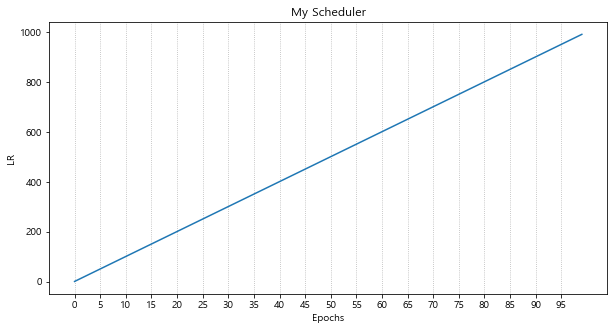

In [34]:
#테스트
plot_lr("My Scheduler",list(range(1,1000,10)))

#### StepLR

In [35]:
optimizer = torch.optim.Adam(bn_model.parameters(),lr=0.001)
#lr_scheduler : optimizer의 lr는 초기 학습률이다.


step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, #학습률을 변화시킬 Optimizer
                                                step_size=30, #몇 step/epoch 마다 lr을 변경시킬지 간격을 정한다.
                                                gamma=0.5, #변경 비율. new_lr = 현재_lr*gamma
                                                )


#optimizer의 lr을 30에폭 마다 0.5배씩 변경하자.



In [36]:
#현재 lr 조회
optimizer.param_groups[0]['lr'],step_scheduler.get_last_lr()

(0.001, [0.001])

In [37]:
N_EPOCHS = 200
STEP_SIZE = 10
steplr_list =[] #epoch별 lr를 저장할 변수.




for epoch in range(N_EPOCH):
    
    #step
    for step in range(STEP_SIZE): #for x,y in dataloader:
        # 학습
        #모델 예측 -> loss 계산 -> 파라미터 업데이트
        optimizer.step()
        #learning rate 변경 요청. =>30번 요청이 들어오면 변경한다. 
        ##step 단위로 변경한다.
    step_scheduler.step() #epoch 단위로 변경.
    steplr_list.append(step_scheduler.get_last_lr()[0]) #현재 epoch의 lr을 저장한다.
    
        

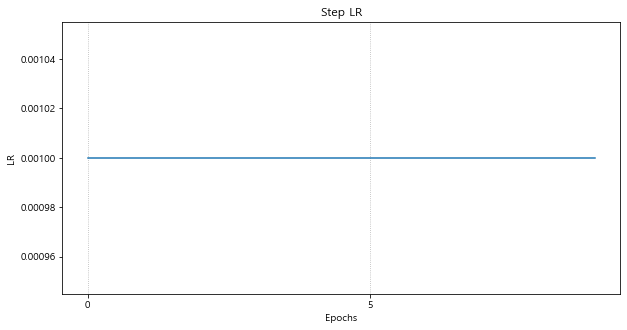

In [38]:
plot_lr("Step LR",steplr_list)

#### CosineAnnealingLR
cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.

In [39]:
#가열 <-> 냉각


optimizer = torch.optim.Adam(bn_model.parameters(),lr=0.001)
ca_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10,eta_min=0.0001,
                                                         )


#범위: 초기 LR ~eta_min

In [40]:
ca_lr_list =[]

for epoch in range(N_EPOCH):
    #한 애폭
    for step in range(STEP_SIZE):
        #한 스텝
        optimizer.step()
        
    ca_scheduler.step()
    ca_lr_list.append(ca_scheduler.get_last_lr()[0])

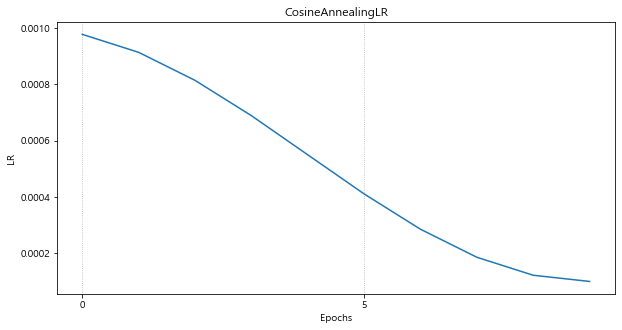

In [89]:
plot_lr("CosineAnnealingLR",ca_lr_list)
#떨어졌다 올라갔다 왔다갔다.....

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)

In [41]:
optimizer = torch.optim.Adam(bn_model.parameters(),lr=0.001)
caws_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
optimizer,
T_0=10, #초기 변화 주기(cycle)
T_mult=2, #변화주기를 어떤 비율로 변경할지를 정한다. T_0 * T_mult = 새주기
eta_min=0.00001, #1e-5 로도 쓸 수 있다. 최소학습률
verbose=True #학습률 변경할 때 마다 로그 출력.




)
#변화 범위: 초기 학습률 ~ eta_min


Epoch 00000: adjusting learning rate of group 0 to 1.0000e-03.


In [42]:
caws_lr_list=[]


for epoch in range(N_EPOCH):
    #한 에폭
    for step in range(STEP_SIZE):
        #한 스텝
        optimizer.step()
    caws_scheduler.step()
    caws_lr_list.append(caws_scheduler.get_last_lr()[0])

Epoch 00001: adjusting learning rate of group 0 to 9.7577e-04.
Epoch 00002: adjusting learning rate of group 0 to 9.0546e-04.
Epoch 00003: adjusting learning rate of group 0 to 7.9595e-04.
Epoch 00004: adjusting learning rate of group 0 to 6.5796e-04.
Epoch 00005: adjusting learning rate of group 0 to 5.0500e-04.
Epoch 00006: adjusting learning rate of group 0 to 3.5204e-04.
Epoch 00007: adjusting learning rate of group 0 to 2.1405e-04.
Epoch 00008: adjusting learning rate of group 0 to 1.0454e-04.
Epoch 00009: adjusting learning rate of group 0 to 3.4227e-05.
Epoch 00010: adjusting learning rate of group 0 to 1.0000e-03.


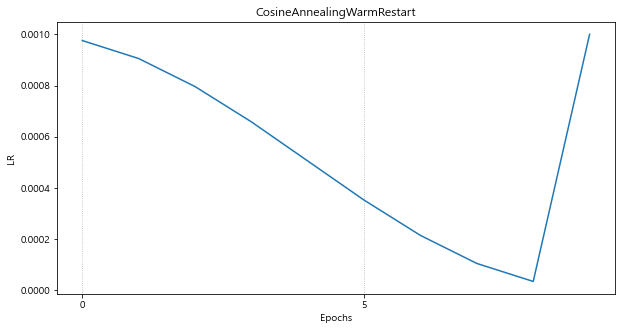

In [43]:
plot_lr("CosineAnnealingWarmRestart",caws_lr_list)